In [2]:
import torch
import gpytorch
from tools import plot, plotarray
import numpy as np


seed = 40

# Set seeds for reproducibility
np.random.seed(seed)
torch.manual_seed(seed)

def make_y(x):
    noise = np.random.normal(0, 5, size=x.shape) 
    y = 3.2 * x + 3.2 + noise

    return y

X_train = torch.linspace(-4, 4, 20, dtype=torch.float32)
y_train = torch.tensor(make_y(X_train.numpy()), dtype=torch.float32, requires_grad=False)

y_train_mean = y_train.mean()
y_train_std = y_train.std()

y_train = (y_train - y_train_mean) / y_train_std

X_test = torch.linspace(-6, 6, 200, dtype=torch.float32)
y_test = torch.tensor(make_y(X_test.numpy()), dtype=torch.float32, requires_grad=False)
y_test = (y_test - y_train_mean) / y_train_std

In [30]:
# Define GP model
class GP_mu0_sigmaLinearRBF(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        
        # Learnable linear mean function: μ(x) = a·x + b
        self.mean_module = gpytorch.means.ConstantMean()
        
        # RBF kernel
        self.covar_module = (
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel())
            +
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(
                lengthscale_prior=gpytorch.priors.NormalPrior(0, 5),
            ))
        )
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    

# Define GP model
class GP_muLinear_sigmaRBF(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        
        # Learnable linear mean function: μ(x) = a·x + b
        self.mean_module = gpytorch.means.LinearMean(input_size=1)
        
        # RBF kernel
        self.covar_module = (
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(
                lengthscale_prior=gpytorch.priors.NormalPrior(0, 5),
            ))
        )
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def train_predict(X, y, Model=GP_mu0_sigmaLinearRBF, epochs=100):
    likelihood = gpytorch.likelihoods.GaussianLikelihood() 
    model = Model(X, y, likelihood)

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.4)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    with torch.no_grad(), gpytorch.settings.prior_mode():
        pred = likelihood(model(X))
        mu_prior = pred.mean.numpy().view(plotarray)
        var = pred.variance
        std_prior = var.sqrt().numpy().view(plotarray)
        samples_prior = pred.sample(torch.Size([10])).numpy().view(plotarray)

    for i in range(epochs):
        optimizer.zero_grad()
        output = model(X)
        loss = -mll(output, y)
        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred = likelihood(model(X))
        mu = pred.mean.numpy().view(plotarray)
        var = pred.variance
        std = var.sqrt().numpy().view(plotarray)

    samples = pred.sample(torch.Size([10])).numpy().view(plotarray)

    return (mu, std, samples), (mu_prior, std_prior, samples_prior)

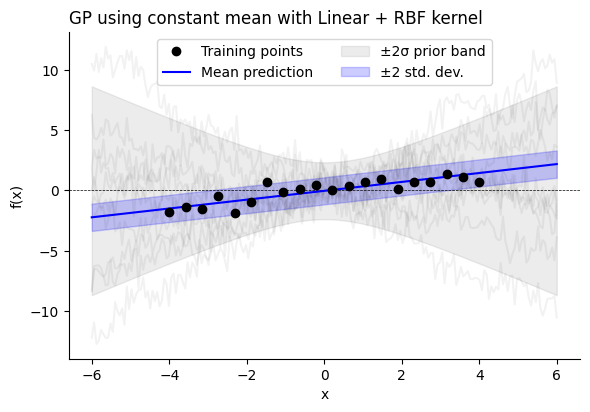

In [31]:
model = GP_mu0_sigmaLinearRBF
train_out, train_prior = train_predict(X_train, y_train, Model=model)
test_out, test_prior = train_predict(X_test, y_test, Model=model)

fig, ax1 = plot(X_train, y_train, X_test, test_out[0], test_out[1], mu_prior=test_prior[0], std_prior=test_prior[1], samples_prior=test_prior[2])

ax1.set_title("GP using constant mean with Linear + RBF kernel", loc='left')
fig.savefig('./imgs/basic_gpytorch-muConst-sigmaLinearRBF.png', transparent=True, dpi=140, bbox_inches='tight')

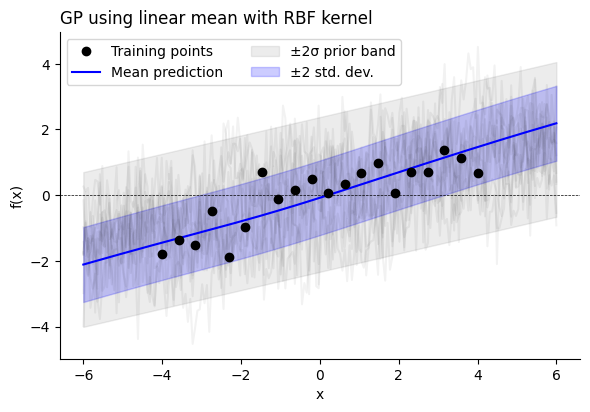

In [32]:
model = GP_muLinear_sigmaRBF
train_out, train_prior = train_predict(X_train, y_train, Model=model)
test_out, test_prior = train_predict(X_test, y_test, Model=model)

fig, ax1 = plot(X_train, y_train, X_test, test_out[0], test_out[1], mu_prior=test_prior[0], std_prior=test_prior[1], samples_prior=test_prior[2])

ax1.set_title("GP using linear mean with RBF kernel", loc='left')
fig.savefig('./imgs/basic_gpytorch-muLinear-sigmaRBF.png', transparent=True, dpi=140, bbox_inches='tight')